# Initialization

## Import of useful modules:

In [1]:
%matplotlib inline
import os, sys
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
from tqdm.notebook import tqdm

from time import sleep, monotonic, time
import datetime as dt

import qcodes as qc
from qcodes import Parameter
from qcodes import initialise_or_create_database_at
from qcodes.dataset.plotting import plot_dataset, plot_by_id
from qcodes.utils.metadata import diff_param_values
from qcodes.instrument.specialized_parameters import ElapsedTimeParameter
from qcodes.dataset.measurements import Measurement

sys.path.append("C:/Users/TUD206951/Documents/Local_QCoDeS/scripts")
from sweeps import do1d, do2d, time_sweep, measure_until, do1d_until

import warnings
warnings.filterwarnings('ignore')

Next we initializee the instruments. Note that you need to provide the correct fridge name!

In [2]:
fridge_name = 'Gecko'
%run C:\Users\TUD206951\Documents\Local_QCoDeS\scripts\init_fridge.py {fridge_name}

Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:1330543, firmware:A20  /A02) in 0.30s


[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Connected to: KEITHLEY INSTRUMENTS INC. 2000 (serial:4107614, firmware:B01  /A02) in 0.07s


[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Connected to: Stanford_Research_Systems SR830 (serial:s/n47557, firmware:ver1.07) in 0.09s
Connected to: Stanford_Research_Systems SR830 (serial:s/n43309, firmware:ver1.07) in 0.07s
Connected to: LSCI 332S (serial:332557, firmware:112002) in 0.07s
Initialized IVVI-rack in 0.03s


Here are all the instruments we have:

In [3]:
station.components

{'keithley_1': <Keithley_2000: keithley_1>,
 'keithley_2': <Keithley_2000: keithley_2>,
 'lockin_1': <SR830: lockin_1>,
 'lockin_2': <SR830: lockin_2>,
 'lakeshore': <Model_332: lakeshore>,
 'ivvi': <IVVI: ivvi>}

Zero dacs and lockin

In [46]:
ivvi.set_dacs_zero()
lockin_1.amplitude(0.004)
lockin_2.amplitude(0.004)

Change the dac rate (same idea as with qtlab, but two commands are used)

## DAC rates

In [4]:
ivvi.dac1.step = 10
ivvi.dac1.inter_delay = 0.01
ivvi.dac2.step = 10
ivvi.dac2.inter_delay = 0.01
ivvi.dac3.step = 50
ivvi.dac3.inter_delay = 0.01

## Database initialisation

In [5]:
date = str(dt.date.today())
db_path = "C:/Users/TUD206951/Documents/LOCAL_DATA/Ivan/NbTiN"
initialise_or_create_database_at(db_path + "/" + "NbTiN" + date + ".db" )

# Scaled parameters

It is more convenient to use meaningful parameters with correct units

In [6]:
from qcodes import ManualParameter, ScaledParameter

## Defining scaled parameters

In [7]:
Irange = Parameter('Irange', label='current range', unit='', set_cmd=None, get_cmd=None)

#division paraemtrs required for simplier update: they used as an argument for scaled paraemtrs of sorce instruments

Irange_division = Parameter('Irange_division', 
                            label='scaled current range', unit='', 
                            set_cmd=None, get_cmd=lambda : 1000 / Irange())


Irange_AC_division = Parameter('Irange_AC_division', 
                               label='scaled current range for lockin', unit='', 
                               set_cmd=None, get_cmd=lambda : 100 / Irange())


Gain_K1 = Parameter('Gain_K1', label='Gain K1', unit='', set_cmd=None, get_cmd=None)
Gain_K2 = Parameter('Gain_K2', label='Gain K2', unit='', set_cmd=None, get_cmd=None)
Gain_L1 = Parameter('Gain_L1', label='Gain L1', unit='', set_cmd=None, get_cmd=None)
Gain_L2 = Parameter('Gain_L2', label='Gain L2', unit='', set_cmd=None, get_cmd=None)

#Add components
station.add_component(Irange)

station.add_component(Irange_division)

station.add_component(Irange_AC_division)
                             
station.add_component(Gain_K1)
station.add_component(Gain_K2)
station.add_component(Gain_L1)
station.add_component(Gain_L2)

'Gain_L2'

## IVVI rack parameters - update here during measuerements

Also can be coppied to execute later

In [8]:
Irange.set(10e-6)
Gain_K1.set(1e3)
Gain_K2.set(1e3)
# Gain_K3.set(1e2)
Gain_L1.set(Gain_K1())
Gain_L2.set(Gain_K2())

#division parameters are updated automatically

## DC parameters - assigning devices
Check that devicies are correct!

In [9]:
appl_current_1 = ScaledParameter(ivvi.dac1, division = Irange_division, name = 'appl_current_1', unit = 'A')
appl_current_2 = ScaledParameter(ivvi.dac2, division = Irange_division, name = 'appl_current_2', unit = 'A')
appl_current_3 = ScaledParameter(ivvi.dac3, division = Irange_division, name = 'appl_current_3', unit = 'A')

meas_voltage_K1 = ScaledParameter(keithley_1.amplitude, division = Gain_K1, name = 'meas_voltage_K1', unit = 'V')

station.add_component(appl_current_1)
station.add_component(appl_current_2)
station.add_component(appl_current_3)
station.add_component(meas_voltage_K1)

'meas_voltage_K1'

## AC parameters

In [10]:
appl_current_AC_1 = ScaledParameter(lockin_1.amplitude, division = Irange_AC_division, name = 'appl_current_1_AC', unit = 'A')
appl_current_AC_2 = ScaledParameter(lockin_2.amplitude, division = Irange_AC_division, name = 'appl_current_2_AC', unit = 'A')

station.add_component(appl_current_AC_1)
station.add_component(appl_current_AC_2)

meas_voltage_AC_L1 = ScaledParameter(lockin_1.X, division = Gain_L1, name = 'meas_voltage_Lockin1', unit = 'V')
meas_voltage_AC_L2 = ScaledParameter(lockin_2.X, division = Gain_L2, name = 'meas_voltage_Lockin2', unit = 'V')

station.add_component(meas_voltage_AC_L1)
station.add_component(meas_voltage_AC_L2)

'meas_voltage_Lockin2'

### Also might be important to store lokin R!

In [11]:
meas_voltage_AC_L1_R = ScaledParameter(lockin_1.R, division = Gain_L1, name = 'meas_voltage_R_Lockin1', unit = 'V')
meas_voltage_AC_L2_R = ScaledParameter(lockin_2.R, division = Gain_L2, name = 'meas_voltage_R_Lockin2', unit = 'V')

station.add_component(meas_voltage_AC_L1_R)
station.add_component(meas_voltage_AC_L2_R)

'meas_voltage_R_Lockin2'

# Extract R

In [12]:
def get_R_from_IV(dataid):
    dataset = qc.load_by_id(dataid)

    voltage = dataset.get_parameter_data()['meas_voltage_K1']['meas_voltage_K1']
    current = dataset.get_parameter_data()['meas_voltage_K1']['appl_current_3']
    fit_values = np.polyfit(current,voltage,1)
    
    return fit_values[0]

# Fast IV to get R

In [21]:
I_lim_r_IV = 1e-6
N_point_r_IV = 20
delay_r_IV = 0.02

In [26]:
def get_R_from_IV_1():
    I_vals = np.linspace(-I_lim_r_IV, I_lim_r_IV, N_point_r_IV)
    V_vals_1 = np.zeros_like(I_vals)
    appl_current_3.post_delay = delay_r_IV
    appl_current_3(-I_lim_r_IV)
    sleep(2*delay_r_IV)
    for i, I_val in enumerate(I_vals):
        appl_current_3(I_val)
        V_vals_1[i] = meas_voltage_K1()
        
    fit_values_1 = np.polyfit(I_vals,V_vals_1,1)
    appl_current_3(-I_lim_r_IV)
    return fit_values_1[0]

In [28]:
import time
start_time = time.time()
print(get_R_from_IV_1())
print("--- %s seconds ---" % (time.time() - start_time))

23.147320297492872
--- 1.3260653018951416 seconds ---


In [29]:
r_from_IV = Parameter('r_from_IV', 
                       label='resistance from fast IV K1 fit', unit='Ohm', 
                       set_cmd=None, get_cmd=get_R_from_IV_1)

# Standard sweeps: setting parameter

## 1D sweeps

In [ ]:
appl_current_3(-1e-6)
exp = qc.new_experiment('IV-curve at 300K', sample_name='simulator_100Ohm')
dataid = do1d(appl_current_3, -1e-6, 1e-6, 100, 0.1, meas_voltage_K1)
#sweep current from -10uA to 10uA 100 points with 0.2sec delay
#records voltage on keithley and lockin
ivvi.set_dacs_zero()

In [ ]:
plot_by_id(dataid)

In [19]:
lakeshore.A.temperature()

26.689

In [38]:
appl_current_AC_1(100e-9)

In [40]:
meas_voltage_AC_L1()/appl_current_AC_1()

10.3737

In [35]:
lockin_1.amplitude(0.004)
lockin_2.amplitude(0.004)

In [18]:
appl_current_AC_2(100e-9)

In [ ]:
meas_voltage_AC_L2()/appl_current_AC_2()

# Measurements during cool down and warm up

In [20]:
def temp_limit(temp, measured_values):
    return temp() < 5

exp = qc.new_experiment('R_vs_temp_CD', sample_name='L1=18, L2=19, rIV=21 + rline(3probe)')

dataid = measure_until(lakeshore.A.temperature, temp_limit, 4, 
                       meas_voltage_AC_L1, meas_voltage_AC_L2, r_from_IV)

Starting experimental run with id: 6. 


In [ ]:
def temp_limit(temp, measured_values):
    return temp() > 290

exp = qc.new_experiment('V_AC&R_vs_temp_WarmUp', sample_name='L1=18, L2=19, rIV=21 + rline(3probe)')
# current(10e-6)
# appl_current_AC(100e-9)
dataid = measure_until(lakeshore.A.temperature, temp_limit, 3, 
                       meas_voltage_AC_L1, meas_voltage_AC_L2, r_from_IV)

# Using heater

In [37]:
lakeshore.heater_output.setpoint(13)

In [25]:
# appl_current_AC(100e-9)
station.snapshot(update=True);
exp = qc.load_or_create_experiment(experiment_name='V_AC&R-vs-set_temp_up_slow', 
                                   sample_name='L1=18, L2=19, rIV=21 + rline(3probe)')

start = 13
stop = 17
num_points = 121

#Register independent parameters
meas = Measurement()
meas.register_parameter(lakeshore.A.temperature)

#Register dependent parametrs
param_meas = [meas_voltage_AC_L1, meas_voltage_AC_L2, r_from_IV]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(lakeshore.A.temperature,))
    output.append([parameter, None])

#Start measuremnts
with meas.run() as datasaver:
    for set_point in np.linspace(start, stop, num_points):
        #set temperature and wait
        lakeshore.heater_output.setpoint(set_point)
        sleep(10)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((lakeshore.A.temperature, lakeshore.A.temperature()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count
[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Starting experimental run with id: 7. 


In [41]:
# appl_current_AC(100e-9)
station.snapshot(update=True);
exp = qc.load_or_create_experiment(experiment_name='V_AC&R-vs-set_temp_up_slow', 
                                   sample_name='L1=21 + rline(3probe)')

start = 13
stop = 17
num_points = 121

#Register independent parameters
meas = Measurement()
meas.register_parameter(lakeshore.A.temperature)

#Register dependent parametrs
param_meas = [meas_voltage_AC_L1]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(lakeshore.A.temperature,))
    output.append([parameter, None])

#Start measuremnts
with meas.run() as datasaver:
    for set_point in np.linspace(start, stop, num_points):
        #set temperature and wait
        lakeshore.heater_output.setpoint(set_point)
        sleep(10)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((lakeshore.A.temperature, lakeshore.A.temperature()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count
[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Starting experimental run with id: 9. 


In [30]:
# appl_current_AC(100e-9)
station.snapshot(update=True);
exp = qc.load_or_create_experiment(
    experiment_name='V_AC&R-vs-set_temp_down_slow', 
    sample_name='L1=18, L2=19, rIV=21 + rline(3probe)')

start = 17
stop = 13
num_points = 121

#Register independent parameters
meas = Measurement()
meas.register_parameter(lakeshore.A.temperature)

#Register dependent parametrs
param_meas = [meas_voltage_AC_L1, meas_voltage_AC_L2, r_from_IV]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(lakeshore.A.temperature,))
    output.append([parameter, None])

#Start measuremnts
with meas.run() as datasaver:
    for set_point in np.linspace(start, stop, num_points):
        #set temperature and wait
        lakeshore.heater_output.setpoint(set_point)
        sleep(15)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((lakeshore.A.temperature, lakeshore.A.temperature()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count
[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Starting experimental run with id: 8. 


An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-0178d5b4139d;
Traceback:
Traceback (most recent call last):
  File "<ipython-input-30-39c044ff6011>", line 27, in <module>
    sleep(15)
KeyboardInterrupt



KeyboardInterrupt: 

In [42]:
# appl_current_AC(100e-9)
station.snapshot(update=True);
exp = qc.load_or_create_experiment(experiment_name='V_AC&R-vs-set_temp_down_slow', 
                                   sample_name='L1=21 + rline(3probe)')

start = 17
stop = 13
num_points = 121

#Register independent parameters
meas = Measurement()
meas.register_parameter(lakeshore.A.temperature)

#Register dependent parametrs
param_meas = [meas_voltage_AC_L1]
output = []
for parameter in param_meas:
    meas.register_parameter(parameter, setpoints=(lakeshore.A.temperature,))
    output.append([parameter, None])

#Start measuremnts
with meas.run() as datasaver:
    for set_point in np.linspace(start, stop, num_points):
        #set temperature and wait
        lakeshore.heater_output.setpoint(set_point)
        sleep(10)
        for i, parameter in enumerate(param_meas):
            output[i][1] = parameter.get()
        datasaver.add_result((lakeshore.A.temperature, lakeshore.A.temperature()),
                             *output)
dataid = datasaver.run_id  # convenient to have for plotting

[keithley_1(Keithley_2000)] Snapshot: Could not update parameter: trigger_count
[keithley_2(Keithley_2000)] Snapshot: Could not update parameter: trigger_count


Starting experimental run with id: 10. 


An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-0178d5ddc19e;
Traceback:
Traceback (most recent call last):
  File "<ipython-input-42-600132581354>", line 26, in <module>
    sleep(10)
KeyboardInterrupt



KeyboardInterrupt: 

In [43]:
lakeshore.heater_output.setpoint(2)

([<AxesSubplot:title={'center':'Run #10, Experiment V_AC&R-vs-set_temp_down_slow (L1=21 + rline(3probe))'}, xlabel='Temperature (K)', ylabel='meas_voltage_Lockin1 (μV)'>],
 [None])

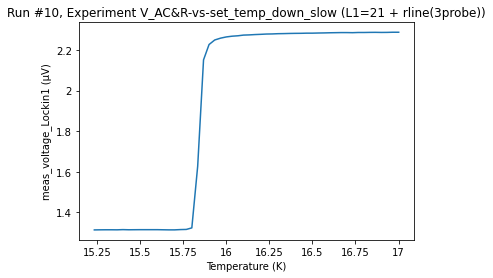

In [45]:
plot_by_id(10)

# Analysis

In [47]:
import matplotlib

In [48]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 

In [59]:
dataset = qc.load_by_id(7)
current_AC = dataset.snapshot['station']['parameters']['appl_current_1_AC']['value']

voltage_18_up = dataset.get_parameter_data()['meas_voltage_Lockin1']['meas_voltage_Lockin1']
temp_18_up = dataset.get_parameter_data()['meas_voltage_Lockin1']['lakeshore_A_temperature']
R_18_up = voltage_18_up / current_AC

voltage_19_up = dataset.get_parameter_data()['meas_voltage_Lockin2']['meas_voltage_Lockin2']
temp_19_up = dataset.get_parameter_data()['meas_voltage_Lockin2']['lakeshore_A_temperature']
R_19_up = voltage_19_up / current_AC

In [60]:
dataset = qc.load_by_id(9)
current_AC = dataset.snapshot['station']['parameters']['appl_current_1_AC']['value']

voltage_21_up = dataset.get_parameter_data()['meas_voltage_Lockin1']['meas_voltage_Lockin1']
temp_21_up = dataset.get_parameter_data()['meas_voltage_Lockin1']['lakeshore_A_temperature']
R_21_up = voltage_21_up / current_AC

In [61]:
dataset = qc.load_by_id(8)
current_AC = dataset.snapshot['station']['parameters']['appl_current_1_AC']['value']

voltage_18_down = dataset.get_parameter_data()['meas_voltage_Lockin1']['meas_voltage_Lockin1']
temp_18_down = dataset.get_parameter_data()['meas_voltage_Lockin1']['lakeshore_A_temperature']
R_18_down = voltage_18_down / current_AC

voltage_19_down = dataset.get_parameter_data()['meas_voltage_Lockin2']['meas_voltage_Lockin2']
temp_19_down = dataset.get_parameter_data()['meas_voltage_Lockin2']['lakeshore_A_temperature']
R_19_down = voltage_19_down / current_AC

In [62]:
dataset = qc.load_by_id(10)
current_AC = dataset.snapshot['station']['parameters']['appl_current_1_AC']['value']

voltage_21_down = dataset.get_parameter_data()['meas_voltage_Lockin1']['meas_voltage_Lockin1']
temp_21_down = dataset.get_parameter_data()['meas_voltage_Lockin1']['lakeshore_A_temperature']
R_21_down = voltage_21_down / current_AC

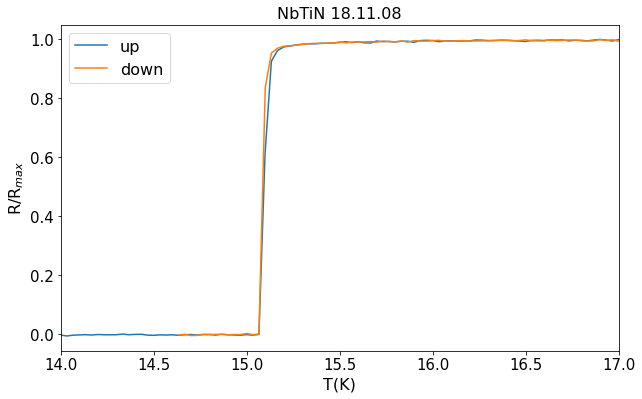

In [70]:
fig, ax = plt.subplots(1, figsize = (10,6))
ax.plot(temp_18_up, R_18_up/np.max(R_18_up), label = 'up')
ax.plot(temp_18_down, R_18_down/np.max(R_18_up), label = 'down')

# ax.axvline(9.45, color = 'gray', linestyle =':', linewidth = 3, label = '9.45K')

ax.legend(fontsize = 16)
ax.set_xlim(14, 17)
ax.set_xlabel('T(K)')
ax.set_ylabel(r'R/R$_{max}$')
plt.title('NbTiN 18.11.08', fontsize = 16)
plt.savefig('C:/Users/TUD206951/Documents/LOCAL_DATA/Ivan/NbTiN/plots/R18_vs_temp.png')

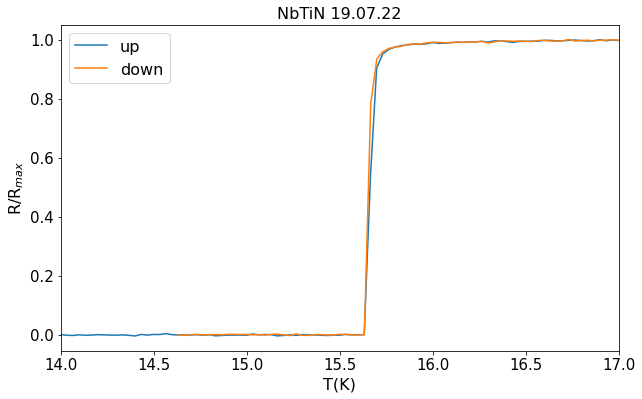

In [71]:
fig, ax = plt.subplots(1, figsize = (10,6))
ax.plot(temp_19_up, R_19_up/np.max(R_19_up), label = 'up')
ax.plot(temp_19_down, R_19_down/np.max(R_19_up), label = 'down')

# ax.axvline(9.45, color = 'gray', linestyle =':', linewidth = 3, label = '9.45K')

ax.legend(fontsize = 16)
ax.set_xlim(14, 17)
ax.set_xlabel('T(K)')
ax.set_ylabel(r'R/R$_{max}$')
plt.title('NbTiN 19.07.22', fontsize = 16)
plt.savefig('C:/Users/TUD206951/Documents/LOCAL_DATA/Ivan/NbTiN/plots/R19_vs_temp.png')

In [72]:
R_line = np.average(R_21_up[temp_21_up<15])
R_line

13.15784

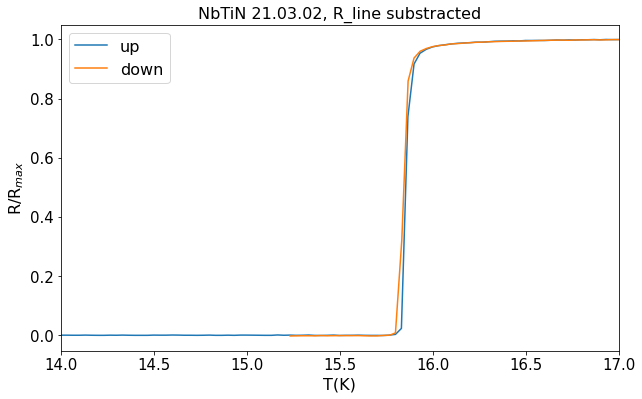

In [73]:
fig, ax = plt.subplots(1, figsize = (10,6))
ax.plot(temp_21_up, (R_21_up-R_line)/np.max(R_21_up-R_line), label = 'up')
ax.plot(temp_21_down, (R_21_down-R_line)/np.max(R_21_up-R_line), label = 'down')

# ax.axvline(9.45, color = 'gray', linestyle =':', linewidth = 3, label = '9.45K')

ax.legend(fontsize = 16)
ax.set_xlim(14, 17)
ax.set_xlabel('T(K)')
ax.set_ylabel(r'R/R$_{max}$')
plt.title('NbTiN 21.03.02, R_line substracted', fontsize = 16)
plt.savefig('C:/Users/TUD206951/Documents/LOCAL_DATA/Ivan/NbTiN/plots/R21_vs_temp.png')

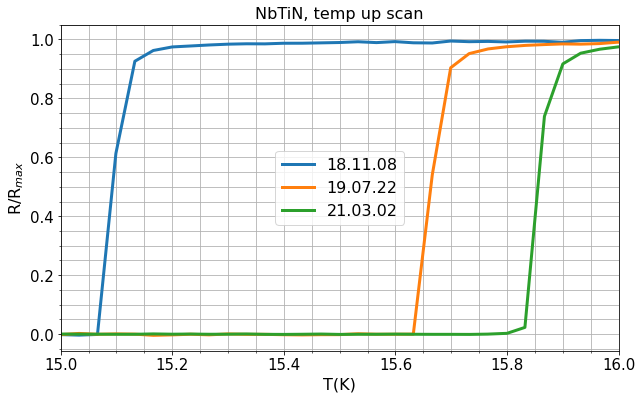

In [86]:
fig, ax = plt.subplots(1, figsize = (10,6))

ax.plot(temp_18_up, R_18_up/np.max(R_18_up), label = '18.11.08', linewidth = 3)
ax.plot(temp_19_up, R_19_up/np.max(R_19_up), label = '19.07.22', linewidth = 3)
ax.plot(temp_21_up, (R_21_up-R_line)/np.max(R_21_up-R_line), label = '21.03.02', linewidth = 3)

# ax.axvline(9.45, color = 'gray', linestyle =':', linewidth = 3, label = '9.45K')

ax.legend(fontsize = 16)
ax.set_xlim(15, 16)
ax.set_xlabel('T(K)')
ax.set_ylabel(r'R/R$_{max}$')
plt.minorticks_on()
plt.grid()
plt.grid(b=True, which='minor')
plt.title('NbTiN, temp up scan', fontsize = 16)
plt.savefig('C:/Users/TUD206951/Documents/LOCAL_DATA/Ivan/NbTiN/plots/R_all_up_vs_temp.png')

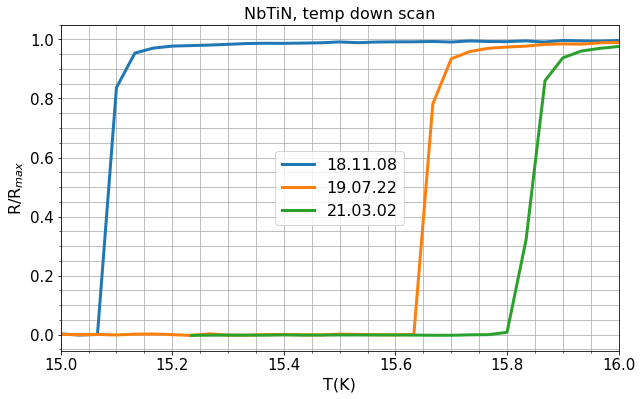

In [87]:
fig, ax = plt.subplots(1, figsize = (10,6))

ax.plot(temp_18_down, R_18_down/np.max(R_18_down), label = '18.11.08', linewidth = 3)
ax.plot(temp_19_down, R_19_down/np.max(R_19_down), label = '19.07.22', linewidth = 3)
ax.plot(temp_21_down, (R_21_down-R_line)/np.max(R_21_down-R_line), label = '21.03.02', linewidth = 3)

# ax.axvline(9.45, color = 'gray', linestyle =':', linewidth = 3, label = '9.45K')

ax.legend(fontsize = 16)
ax.set_xlim(15, 16)
ax.set_xlabel('T(K)')
ax.set_ylabel(r'R/R$_{max}$')
plt.minorticks_on()
plt.grid()
plt.grid(b=True, which='minor')
plt.title('NbTiN, temp down scan', fontsize = 16)
plt.savefig('C:/Users/TUD206951/Documents/LOCAL_DATA/Ivan/NbTiN/plots/R_all_down_vs_temp.png')

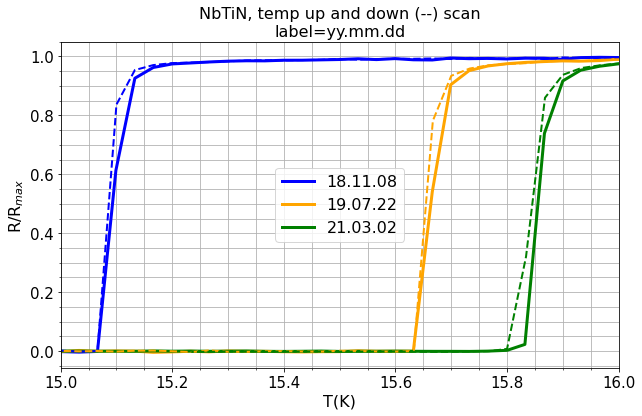

In [93]:
fig, ax = plt.subplots(1, figsize = (10,6))

ax.plot(temp_18_up, R_18_up/np.max(R_18_up), label = '18.11.08', linewidth = 3, c='blue')
ax.plot(temp_19_up, R_19_up/np.max(R_19_up), label = '19.07.22', linewidth = 3, c='orange')
ax.plot(temp_21_up, (R_21_up-R_line)/np.max(R_21_up-R_line), label = '21.03.02', linewidth = 3, c='green')

ax.plot(temp_18_down, R_18_down/np.max(R_18_down), linewidth = 2, c='blue', ls='--')
ax.plot(temp_19_down, R_19_down/np.max(R_19_down), linewidth = 2, c='orange', ls='--')
ax.plot(temp_21_down, (R_21_down-R_line)/np.max(R_21_down-R_line), linewidth = 2, c='green', ls='--')

# ax.axvline(9.45, color = 'gray', linestyle =':', linewidth = 3, label = '9.45K')

ax.legend(fontsize = 16)
ax.set_xlim(15, 16)
ax.set_xlabel('T(K)')
ax.set_ylabel(r'R/R$_{max}$')
plt.minorticks_on()
plt.grid()
plt.grid(b=True, which='minor')
plt.title('NbTiN, temp up and down (--) scan\nlabel=yy.mm.dd', fontsize = 16)
plt.savefig('C:/Users/TUD206951/Documents/LOCAL_DATA/Ivan/NbTiN/plots/R_all_both_vs_temp.png')